# Assignment

We build on the feature engineering we did in the last assignment and run k-means on the data with RFM features in order to do **customer segmentation**. Since k-means is unsupervised, we will also encounter challenges around interpreting results at the end. 

In [1]:
import pandas as pd
col_names = ['user_id', 'gender', 'address', 'store_id', 'trans_id', 'timestamp', 'item_id', 'quantity', 'dollar']
churn = pd.read_csv("../data/retail-churn.csv", sep = ",", skiprows = 1, names = col_names)
churn.head()

,user_id,gender,address,store_id,trans_id,timestamp,item_id,quantity,dollar
0,101981,F,E,2860,818463,11/1/2000 0:00,4.710000e+12,1,37
1,101981,F,E,2861,818464,11/1/2000 0:00,4.710000e+12,1,17
2,101981,F,E,2862,818465,11/1/2000 0:00,4.710000e+12,1,23
3,101981,F,E,2863,818466,11/1/2000 0:00,4.710000e+12,1,41
4,101981,F,E,2864,818467,11/1/2000 0:00,4.710000e+12,8,288


In [2]:
# check for NaNs
churn.isna().value_counts()

user_id  gender  address  store_id  trans_id  timestamp  item_id  quantity  dollar
False    False   False    False     False     False      False    False     False     252204
dtype: int64

**There are no NaN detected and thus will not have to perform any imputation or dropping of columns**

Run the feature engineering steps on the data to extract RFM features.  

In [3]:
churn['date'] =  pd.to_datetime(pd.to_datetime(churn['timestamp'], format = '%m/%d/%Y %H:%M').dt.date)
churn_agg = churn.groupby(['user_id', 'date']).agg({'dollar': 'sum', 'quantity': 'sum'})
churn_agg = churn_agg.reset_index()
churn_roll = pd.DataFrame()
churn_roll['dollar_roll_sum_7D'] = churn_agg.groupby('user_id').rolling(window = '7D', on = 'date')['dollar'].sum()
churn_roll['quantity_roll_sum_7D'] = churn_agg.groupby('user_id').rolling(window = '7D', on = 'date')['quantity'].sum()
churn_roll = churn_roll.reset_index()
churn_roll['last_visit_ndays'] = churn_agg.groupby('user_id')['date'].diff(periods = 1).dt.days
print(churn_roll.shape)

# Should we impute or drop NaN/NaT in churn_roll['last_visit_ndays']?
imputation_value = churn_roll['last_visit_ndays'].max() # None # 
if imputation_value is None:
    # Drop (Remove all rows with NaN):
    churn_roll.dropna(inplace = True)
    print(churn_roll.shape)
else:
    # Impute (Replace all NaN in last_visit_ndays):
    churn_roll['last_visit_ndays'] = churn_roll['last_visit_ndays'].fillna(imputation_value)

churn_roll.head()

(37058, 5)


,user_id,date,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,1113,2000-11-12,420.0,5.0,118.0
1,1113,2000-11-26,558.0,3.0,14.0
2,1113,2000-11-27,1182.0,9.0,1.0
3,1113,2001-01-06,628.0,9.0,40.0
4,1250,2001-02-04,734.0,5.0,118.0


In [4]:
# check for nans
churn_roll.isna().value_counts()

user_id  date   dollar_roll_sum_7D  quantity_roll_sum_7D  last_visit_ndays
False    False  False               False                 False               37058
dtype: int64

**Double checked for nulls and did not seem to find any in the newly created columns**

The RFM features are:  'dollar_roll_sum_7D', 'quantity_roll_sum_7D', 'last_visit_ndays'

1. Train a k-means algorithm on the 3 normalized RFM features using $k = 10$. What are the cluster centroids? The cluster centroids should be reported in the **original scale**, not the normalized scale. <span style="color:red" float:right>[2 point]</span> 

In [5]:
# import scikit learn packages
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [6]:
# create a dataframe with the 3 numeric columns of interest
rfm_df = churn_roll[['dollar_roll_sum_7D', 'quantity_roll_sum_7D', 'last_visit_ndays']]

# find the means and stds for each column - We will need these to bring out the non-normalized centroids
Means = rfm_df[['dollar_roll_sum_7D', 'quantity_roll_sum_7D', 'last_visit_ndays']].mean(axis=0)
Stds = rfm_df[['dollar_roll_sum_7D', 'quantity_roll_sum_7D', 'last_visit_ndays']].std(axis=0)

# review the means and stds
print(f"Means \n{Means}")
print()
print(f"StDevs \n{Stds}")


Means 
dollar_roll_sum_7D      1233.831157
quantity_roll_sum_7D      13.078445
last_visit_ndays          43.461412
dtype: float64

StDevs 
dollar_roll_sum_7D      2076.198829
quantity_roll_sum_7D      21.839162
last_visit_ndays          47.924183
dtype: float64


**Here I just grabbed the columns of interest and took a look at their means and standard deviations. This was to be able to manually reverse the standardization to have the later clusters in their original values**

In [7]:
# Normalize the three columns using their means and stds
# create a copy of RFM df
rfm_norm = rfm_df.copy()

# normalize each column
rfm_norm['dollar_roll_sum_7D'] = (rfm_norm['dollar_roll_sum_7D'] - Means['dollar_roll_sum_7D'])/Stds['dollar_roll_sum_7D']
rfm_norm['quantity_roll_sum_7D'] = (rfm_norm['quantity_roll_sum_7D'] - Means['quantity_roll_sum_7D'])/Stds['quantity_roll_sum_7D']
rfm_norm['last_visit_ndays'] = (rfm_norm['last_visit_ndays'] - Means['last_visit_ndays'])/Stds['last_visit_ndays']

# review normalized df
rfm_norm.head().round(2)


,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,-0.39,-0.37,1.56
1,-0.33,-0.46,-0.61
2,-0.02,-0.19,-0.89
3,-0.29,-0.19,-0.07
4,-0.24,-0.37,1.56


**Performed the standardization as was shown in class for practice and to use the means and stds from earlier**

In [8]:
# Verify using the apply method to see if there is a similar df
# create another copy of rfm columns
rfm_rescaled = rfm_df.copy()

# use the apply method to create a normalized df
rfm_rescaled = rfm_rescaled.apply(lambda x: (x - x.mean()) / x.std(), axis = 0)

# reveiew dataframe
rfm_rescaled.head().round(2)

,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,-0.39,-0.37,1.56
1,-0.33,-0.46,-0.61
2,-0.02,-0.19,-0.89
3,-0.29,-0.19,-0.07
4,-0.24,-0.37,1.56


**I created a copy to play around with. Here I used the lambda technique from class. This technique is handy, but there is no way to reverse the standardization to the original it seems.**

In [9]:
# use standard scaler just for the sake of it and practice
col_names = ['dollar_roll_sum_7D', 'quantity_roll_sum_7D', 'last_visit_ndays']
rfm_standardized = churn_roll[['dollar_roll_sum_7D', 'quantity_roll_sum_7D', 'last_visit_ndays']]
scaler = StandardScaler()
rfm_standardized = pd.DataFrame(scaler.fit_transform(rfm_standardized), columns=col_names)

rfm_standardized.round(2)

,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,-0.39,-0.37,1.56
1,-0.33,-0.46,-0.61
2,-0.02,-0.19,-0.89
3,-0.29,-0.19,-0.07
4,-0.24,-0.37,1.56
...,...,...,...
37053,-0.41,-0.46,1.56
37054,1.12,0.45,1.56
37055,1.81,1.51,1.56
37056,0.23,0.09,1.56


**Just for fun I decided to call the standardscaler from sklearn. It looks like all three methods gave me the same standardization. The first one is the most useful as I will be able to reverse the standardization and put cluster centroids back in their original context.**

In [10]:
# Use Sklearn to fit the Kmeans algorithm to the normalized data with 10 clusters
# create number of clusters
n_clusters = 10

# create an instance of KMeans model
kmeans = KMeans(n_clusters=n_clusters)

# fit the model to the normalized rfm columns
kmeans.fit(rfm_rescaled)

# add the predicted cluster to the rfm_rescaled df
rfm_rescaled['cluster'] = kmeans.predict(rfm_rescaled)

# review rescaled df
rfm_rescaled.head().round(2)


,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays,cluster
0,-0.39,-0.37,1.56,2
1,-0.33,-0.46,-0.61,5
2,-0.02,-0.19,-0.89,5
3,-0.29,-0.19,-0.07,0
4,-0.24,-0.37,1.56,2


**I added the clusters to the scaled df and it looks like it has worked.**

In [11]:
# create a df with normalized cluster centroids
ScaledCentroids = pd.DataFrame(kmeans.cluster_centers_, columns=rfm_df.columns)

# review df
ScaledCentroids.round(2)


,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,-0.28,-0.27,0.08
1,21.61,10.19,-0.77
2,-0.31,-0.27,1.54
3,0.17,0.22,-0.72
4,8.94,43.94,-0.83
5,-0.37,-0.31,-0.68
6,1.07,0.96,-0.69
7,9.86,3.72,-0.66
8,3.11,2.10,-0.43
9,0.67,0.56,1.50


**These are the centroids for k=10 for the 10 different clusters. Each row representing a point in space for its associated cluster.**

In [12]:
# rescale the cluster centroids using the Means and stds calculated earlier
# create empty dataframe
Centroids = pd.DataFrame()

# reverse normalize each scaled centroid
Centroids = ScaledCentroids * rfm_df[rfm_df.columns].std() + rfm_df[rfm_df.columns].mean()

# review regular centroids
Centroids.round(2)

,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,658.88,7.27,47.48
1,46109.16,235.68,6.48
2,597.73,7.15,117.26
3,1587.42,17.94,8.85
4,19804.40,972.80,3.60
5,469.98,6.28,10.66
6,3462.27,34.06,10.57
7,21705.46,94.26,11.94
8,7688.10,58.85,22.66
9,2618.98,25.40,115.24


**We reverse the original (x - mean) * std and and get the cluster centroids in their original scale**

In [13]:
# use the kmeans labels as another means of verification
# add cluster to original rfm_df
rfm_df['cluster'] = rfm_rescaled.loc[:, 'cluster']

# use the groupby cluster.mean() trick
rfm_df.groupby(by=kmeans.labels_).mean().round(2)

/tmp/ipykernel_73/881358879.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df['cluster'] = rfm_rescaled.loc[:, 'cluster']


,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays,cluster
0,660.02,7.29,47.52,0.0
1,46109.16,235.68,6.48,1.0
2,597.47,7.15,117.26,2.0
3,1583.31,17.90,8.81,3.0
4,19804.40,972.80,3.60,4.0
5,469.03,6.27,10.68,5.0
6,3453.37,34.00,10.62,6.0
7,21705.46,94.26,11.94,7.0
8,7683.44,58.85,22.62,8.0
9,2617.14,25.39,115.25,9.0


**I felt it was necessary to re-add the clusters back to the original dataframe and show that the cluster centroids are the similar, but not the same to the ones calculated before.**

2. Our earlier choice of $k=10$ was arbitrary. To find a better number of $k$ create a **scree plot**, which plots the number of clusters $k$ on the x-axis and the sum of squared distances from each point to its cluster centroid on the y-axis. We can get the latter by calling the `inertia_` attribute as shown in the lab. Plot the scree plot for $k$ values from 1 to 15. <span style="color:red" float:right>[4 point]</span>

In [14]:
# Create models for k=[1-15], fit the models and grab the inertia into a list

# intialize a list and create an easier named df for the loop
inertia_list = []
x = rfm_rescaled[['dollar_roll_sum_7D','quantity_roll_sum_7D','last_visit_ndays']]

**I created a list to hold the k value - inertia pairs. I also recreated the normalized dataframe for our rfm values as a variable x for easier readability.**

In [15]:
""" loop through values 1-15, creating a kmeans model for each number, 
    fitting the model to our data and storing each value in the inertia
    dictionary to eventually transform into an inertia plot.""" 

for i in range(1, 16):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(x)
    inertia_list.append([i, kmeans.inertia_]) 

# view list
inertia_list

[[1, 111170.99999999355],
 [2, 76678.31684839331],
 [3, 50368.83313294873],
 [4, 36746.36553474327],
 [5, 25352.336400121036],
 [6, 20812.818105008817],
 [7, 18263.361546803448],
 [8, 16133.766313865366],
 [9, 14627.103156368092],
 [10, 13411.393313282257],
 [11, 12126.739341707194],
 [12, 10908.025263061323],
 [13, 10066.5309211625],
 [14, 9319.688453971918],
 [15, 8728.908934351808]]

**The for loop that was used shows each cluster and its inertia pair. We can see as the value of k increases the inertia decrease with each iteration.**

In [16]:
# create df
inertia_df = pd.DataFrame(inertia_list, columns=['num_clusters', 'inertia'])

In [17]:
# import plotting packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Scree Plot')

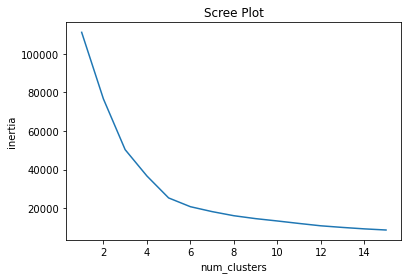

In [18]:
sns.lineplot(x='num_clusters', y='inertia', data=inertia_df)
plt.title('Scree Plot')

3. Based on the scree plot, what is a good value to pick for $k$? Provide a brief justification for your choice. <span style="color:red" float:right>[2 point]</span>

### k=5

**In my opinion 5 clusters appears to be the best value for k. It looks like it still has an elbow while still minimizing inertia to a decent degree. Adding any more clusters could make interpretation more confusing, all though it would be interesting to see the differences between 5 and 6 clusters as a test.**

4. Train a k-means algorithm on the RFM features using your new value of $k$. Report:
- the size (number of items) of each cluster
- the mean of each cluster in the original scale
- the standard deviation of each cluster in the Z-normalized scale
<span style="color:red" float:right>[2 point]</span>

In [19]:
# create a new instance of the KMeans model
kmeans_5 = KMeans(n_clusters=5, random_state=42)

# fit the model
kmeans_5.fit(rfm_standardized)

# add predicted values to the original dataframe
rfm_standardized['cluster'] = kmeans_5.predict(rfm_standardized)

# review dataframe
rfm_standardized

,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays,cluster
0,-0.391987,-0.369911,1.555365,1
1,-0.325518,-0.461491,-0.614759,0
2,-0.024965,-0.186752,-0.886024,0
3,-0.291802,-0.186752,-0.072228,0
4,-0.240747,-0.369911,1.555365,1
...,...,...,...,...
37053,-0.412698,-0.461491,1.555365,1
37054,1.123785,0.454307,1.555365,1
37055,1.810626,1.507475,1.555365,2
37056,0.227423,0.087988,1.555365,1


In [20]:
# create the counts of number of items for each cluster
num_of_items_df = pd.DataFrame(rfm_standardized.groupby('cluster').count())
print("The number of each item in each cluster is:")
num_of_items_df

The number of each item in each cluster is:


,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
cluster,,,
0,23194,23194,23194
1,10639,10639,10639
2,3158,3158,3158
3,57,57,57
4,10,10,10


**It looks like the counts of each column decrease with each cluster.**

In [21]:
# create the original centroids by reversing the normalization for each column

col_names = ['dollar_roll_sum_7D','quantity_roll_sum_7D','last_visit_ndays']

ScaledCentroids_5 = pd.DataFrame(rfm_standardized.groupby('cluster').mean())

Centroids_5 = ScaledCentroids_5 * rfm_df[col_names].std() + rfm_df[col_names].mean()

# review df
print("The original centroids are: ")
Centroids_5

The original centroids are: 


,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
cluster,,,
0,837.399282,10.015049,14.174391
1,927.472979,10.117546,114.878020
2,4500.996584,39.753685,18.685226
3,35457.847731,165.984519,10.543416
4,19804.650566,972.812949,3.599462


In [22]:
# create the variation betweent the normalized clusters
print("The standard deviation between the normalized clusters are: ")
rfm_standardized.groupby('cluster').std()

The standard deviation between the normalized clusters are: 


,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
cluster,,,
0,0.324071,0.328407,0.290993
1,0.429327,0.395609,0.230328
2,1.213000,0.907213,0.653034
3,6.821948,4.869316,0.559493
4,4.994264,12.892315,0.093938


**The variation between each cluster is an interesting data point to look at. It looks like the variation increases wrt dollar_sum for each cluster quite significantly. The quantity_roll has little variation until it gets the clusters 3 and 4. The last_visit seems to decrease in variability as clusters increase.**

5. Pick 3 clusters at random and describe what makes them different from one another (in terms of their RFM features). <span style="color:red" float:right>[3 point]</span>

In [23]:
# create 3 dataframes of each cluster
cluster_1 = rfm_df[rfm_df['cluster'] == 1]
cluster_3 = rfm_df[rfm_df['cluster'] == 3]
cluster_4 = rfm_df[rfm_df['cluster'] == 4]

# create means
means_1 = cluster_1.mean()
means_3 = cluster_3.mean()
means_4 = cluster_4.mean()

In [24]:
# look at the means of each clustered df
from pprint import PrettyPrinter as pp
print(f'The means for cluster 1 are \n {means_1}')
print()
print(f'The means for cluster 3 are \n {means_3}')
print()
print(f'The means for cluster 4 are \n {means_4}')

The means for cluster 1 are 
 dollar_roll_sum_7D      46109.16
quantity_roll_sum_7D      235.68
last_visit_ndays            6.48
cluster                     1.00
dtype: float64

The means for cluster 3 are 
 dollar_roll_sum_7D      1583.312286
quantity_roll_sum_7D      17.895429
last_visit_ndays           8.808286
cluster                    3.000000
dtype: float64

The means for cluster 4 are 
 dollar_roll_sum_7D      19804.4
quantity_roll_sum_7D      972.8
last_visit_ndays            3.6
cluster                     4.0
dtype: float64


Cluster 1 Pairplot


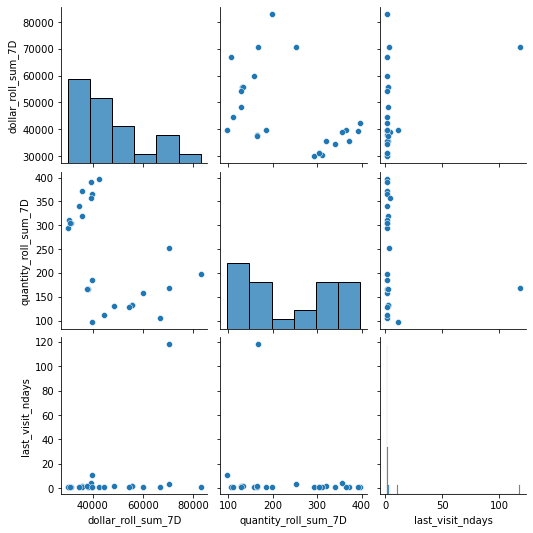

In [25]:
# pairplot each cluster
import seaborn as sns

#pairplots
print('Cluster 1 Pairplot')
sns.pairplot(data=cluster_1[col_names])

Cluster 3 Pairplot


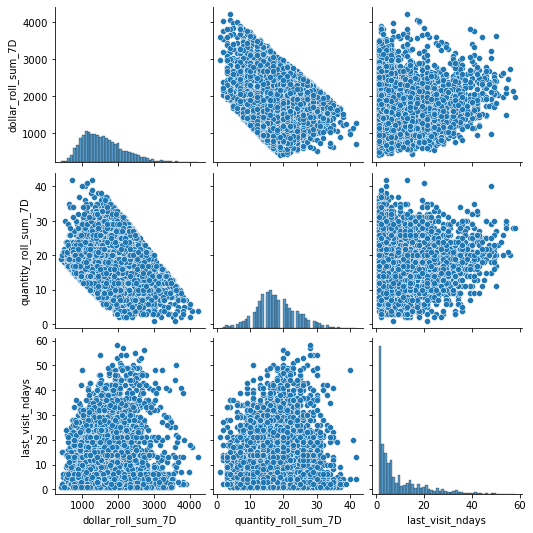

In [26]:
print('Cluster 3 Pairplot')
sns.pairplot(data=cluster_3[col_names])

Cluster 4 Pairplot


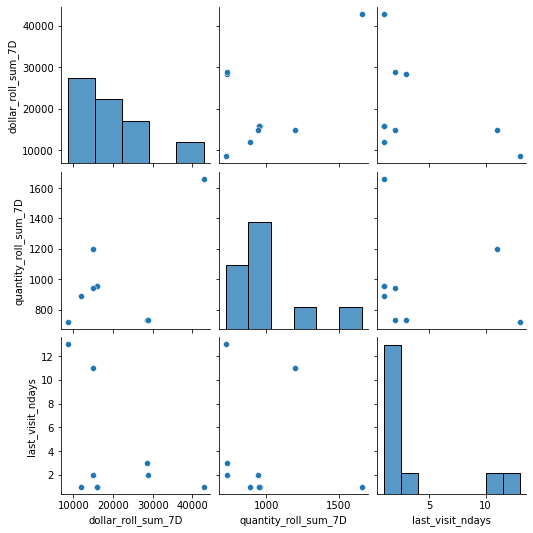

In [27]:
print('Cluster 4 Pairplot')
sns.pairplot(data=cluster_4[col_names])

#### I chose clusters 1, 3 and 4


- We can see just from sheer data points that cluster 1 & cluster 3 have significantly more datapoints than cluster 4 as was seen with the count done earlier.
- The dollar 7 day rolling sum for cluster 1 has values that are upt to around 250, whereas cluster 3 has values up to around 1000 and cluster 4 has values up to 60,000. This is also shown in the average 7 day rolling dollar sums for each cluster where averages for cluster 4 > cluster 3 > cluster 1
- The last visit number of days 7 day rolling sum was interesting. It looked like cluster 4 and cluster 3 had the most recent users. Cluster 1 had the most users that took the longest between visits. 
- Overall we can see a clear difference between these clusters and the patterns associated with them based on the 7 day rolling sums of dollars, quantity of items and days from last visit. 

# End of assignment